In [4]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import random
import statsmodels.tsa.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

#filter warning
import warnings
warnings.filterwarnings('ignore')

START = dt.datetime(2001, 11, 1)
END = dt.datetime(2022, 11, 30)
random.seed(61)

In [5]:
df = pd.read_csv('./LCDMA_October_2022/balanced_can_md.csv')
df = df.set_index(pd.DatetimeIndex(df['Date'])).iloc[:,1:]

num_var =60
df = df.iloc[:,:num_var]


lag_df = df.shift(1)#pd.concat([df.shift(1),df.shift(2)],axis=1)

df = df.iloc[12:]
lag_df = lag_df.iloc[12:]



table = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# Individual stock list in S&P500
stock_list = table[0].iloc[:, 0].to_list()
stock_list = random.sample(stock_list, 25)  # Randomly select 25 stocks

df = web.DataReader(stock_list, 'yahoo', START, END)['Close']

df = df.asfreq('M', method='pad')  # Transfor monthly frequency
df = np.log(df).diff(1).iloc[1:]  # Stationarize the data
df.dropna(axis=1, inplace=True)

lag_df = pd.concat([df.shift(1),df.shift(2)],axis=1)  # Lagged data (2)
df = df.iloc[12:]
lag_df = lag_df.iloc[12:]


In [7]:
# Fit the DFM

num_oos=60
iter=100
testset = df.iloc[-num_oos:]


model = sm.DynamicFactor(endog=df, exog=lag_df, k_factors=2,
                         factor_order=2, error_order=1)
results = model.fit(maxiter=iter, disp=True)

dfm_pred = results.predict(start=df.shape[0]-num_oos, end=df.shape[0]-1, exog=lag_df[-num_oos:])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3848     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.99004D+01    |proj g|=  2.25257D+10


 This problem is unconstrained.


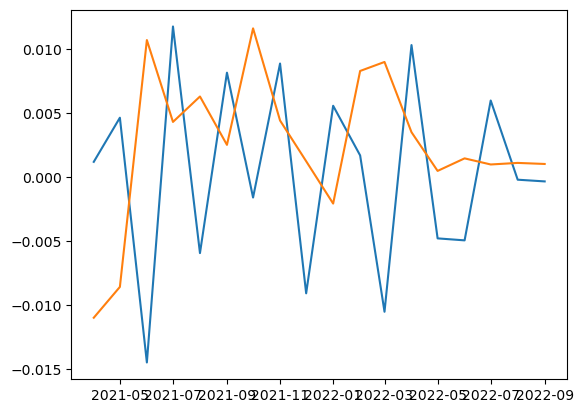

In [ ]:
plt.plot(dfm_pred.iloc[:,1],  label='DFM')
plt.plot(testset.iloc[:,1], label='Actual')
plt.show()

In [ ]:

# Fit the DFM
h=1
dfm_forecast = pd.DataFrame()

model = sm.DynamicFactor(endog=df.iloc[:-num_oos], exog=lag_df[:-num_oos], k_factors=3,
                         factor_order=2, error_order=1)
results = model.fit(maxiter=iter, disp=False)

for i in range(-num_oos,0,h):

    results = results.apply(df.iloc[:i], lag_df.iloc[:i]) # might be
    forecast = results.forecast(steps=h, exog=lag_df.iloc[i])
    dfm_forecast = pd.concat([dfm_forecast, forecast])
    

In [ ]:
mse_dfm = mse(dfm_forecast, testset)
print('MSE of DFM: ', mse_dfm)

MSE of DFM:  0.00028829743502793384


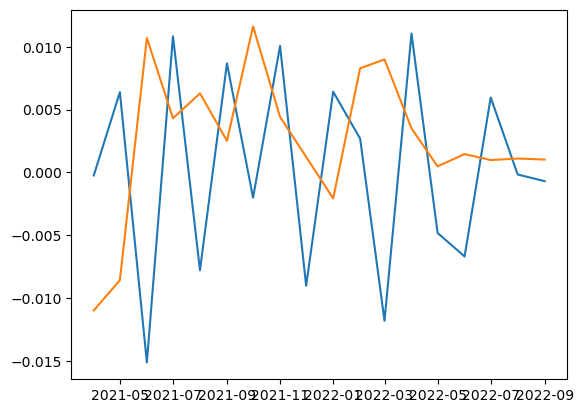

In [ ]:
plt.plot(dfm_forecast.iloc[:,1], label='DFM')
plt.plot(testset.iloc[:,1], label='Actual')
plt.show()

In [ ]:
results = results.apply(df, lag_df)
forecast = results.forecast(steps=h, exog=pd.concat([df.iloc[-1], df.iloc[-2]],axis=1))
forecast

,GDP_new,BSI_new,GPI_new,SPI_new,IP_new,NDM_new,DM_new,OILP_new,CON_new,RT_new
2022-10-01,-0.012619,-0.011261,-0.005428,-0.013897,-0.001114,0.001367,0.011585,0.0058,-0.006349,-0.005143


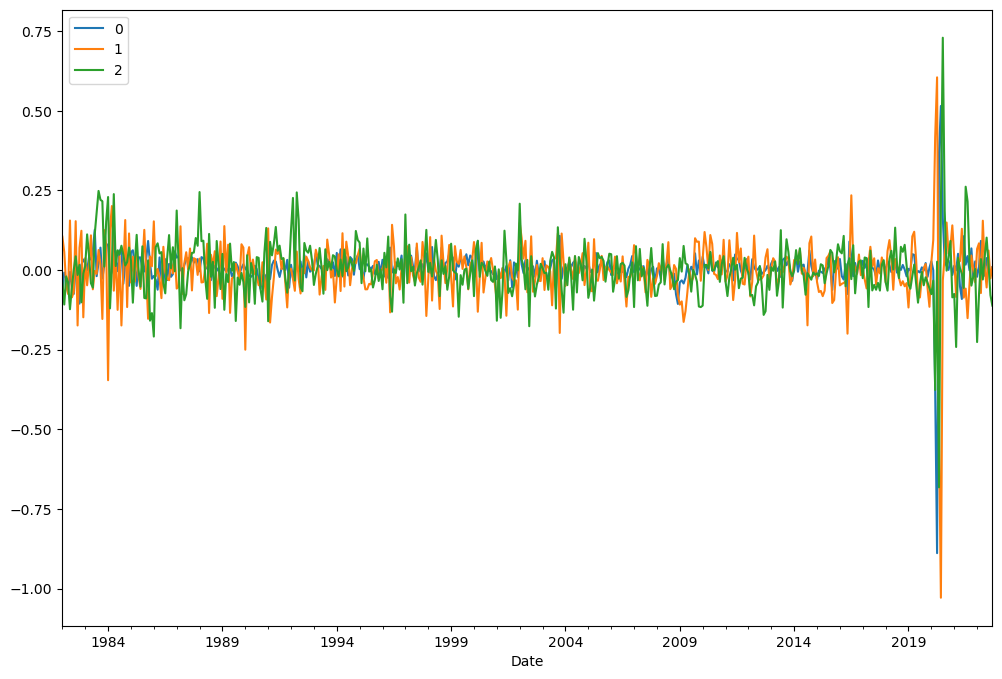

In [ ]:
pd.DataFrame(results.factors.smoothed.T, index=df.index).plot(figsize=(12, 8))
plt.show()

In [ ]:
print(results.summary())

                                                                        Statespace Model Results                                                                        
Dep. Variable:     ['GDP_new', 'BSI_new', 'GPI_new', 'SPI_new', 'IP_new', 'NDM_new', 'DM_new', 'OILP_new', 'CON_new', 'RT_new']   No. Observations:                  489
Model:                                                                                        DynamicFactor(factors=3, order=2)   Log Likelihood               13335.502
                                                                                                                + 20 regressors   AIC                         -26135.003
                                                                                                                 + AR(1) errors   BIC                         -25011.450
Date:                                                                                                          Wed, 14 Dec 2022   HQIC                     